# Battleship

In [1]:
import autogen
from opto.trace import bundle, node
from opto.trace.bundles import TraceExecutionError, trace_class
from opto.optimizers import FunctionOptimizer
from opto.trace.nodes import GRAPH

## Scenario 0: Produce valid code to generate (x, y)
Challenge:
1. Need to have the code from end-to-end that's runnable and throws no exception
2. Does not know the data type of the input
3. Does not know the width/height of the board

In [2]:
from battleship import BattleshipBoard

In [3]:
@bundle("[select_coordinate] Given a map, select a valid coordinate.", trainable=True)
def select_coordinate(map):
    """
    Given a map, select a valid coordinate.
    """
    return map


def user_fb_for_coords_validity(board, coords):
    try:
        board.check_shot(coords[0], coords[1])
        return "Valid coordinates.", 1
    except Exception as e:
        return str(e), 0

In [4]:
GRAPH.clear()

board = BattleshipBoard(10, 10)

x = node(board.board, trainable=False)
optimizer = FunctionOptimizer(
    [select_coordinate.parameter], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST")
)

feedback = ""
reward = 0

while reward != 1:
    try:
        output = select_coordinate(x)
        feedback, reward = user_fb_for_coords_validity(board, output.data)
    except TraceExecutionError as e:
        output = e.exception_node
        feedback = output.data

    optimizer.zero_feedback()
    optimizer.backward(output, feedback)

    print(f"output={output.data}, feedback={feedback}, variables=\n")  # logging
    for p in optimizer.parameters:
        print(p.name, p.data)
    optimizer.step(verbose=False)

output=x, feedback=string index out of range, variables=

__code:0 def select_coordinate(map):
    """
    Given a map, select a valid coordinate.
    """
    return 'x'
output=x, feedback=string index out of range, variables=

__code:0 def select_coordinate(map):
    """
    Given a map, select a valid coordinate.
    """
    return 'x'
output=(0, 0), feedback=Valid coordinates., variables=

__code:0 def select_coordinate(map):
    for i in range(len(map)):
        for j in range(len(map[i])):
            if map[i][j] is not None:
                return (i, j)
    return None


## Scenario 1: Learning to place shots well (single board).
Important: to avoid bias, we can't tell LLM this is a battleship game.

Challenge:
1. Need to know not to place shots on the same spot
2. Need to know to place shots on the board
3. Need to develop basic heuristics (battleships are either vertical or horizontal)

In [4]:
from battleship import BattleshipBoard


@bundle("[select_coordinate] Given a map, select a valid coordinate to see if we can earn reward.", trainable=True)
def select_coordinate(map):
    """
    Given a map, select a valid coordinate. We might earn reward from this coordinate.
    """
    return [0, 0]


def user_fb_for_placing_shot(board, coords):
    # this is already a multi-step cumulative reward problem
    # obs, reward, terminal, feedback
    try:
        reward = board.check_shot(coords[0], coords[1])
        new_map = board.get_shots()
        terminal = board.check_terminate()
        return new_map, reward, terminal, f"Got {int(reward)} reward."
    except Exception as e:
        return board.get_shots(), 0, False, str(e)

In [5]:
GRAPH.clear()

board = BattleshipBoard(5, 5, num_each_type=1, exclude_ships=["C", "B"])

In [6]:
board.visualize_board()

R . . . D
R . . . D
R . . . .
. . . . .
. . S S S



In [7]:
board.get_shots()

[['.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.'],
 ['.', '.', '.', '.', '.']]

In [3]:
GRAPH.clear()

board = BattleshipBoard(5, 5, num_each_type=1, exclude_ships=["C", "B"])
print("Ground State Board")
board.visualize_board()

obs = node(board.get_shots(), trainable=False)
optimizer = FunctionOptimizer(
    [select_coordinate.parameter], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST")
)

feedback = ""
terminal = False
cum_reward = 0
max_calls = 10

while not terminal and max_calls > 0:
    # This is also online optimization
    # we have the opportunity to keep changing the function with each round of interaction
    try:
        output = select_coordinate(obs)
        obs, reward, terminal, feedback = user_fb_for_placing_shot(board, output.data)
    except TraceExecutionError as e:
        # this is essentially a retry
        output = e.exception_node
        feedback = output.data
        terminal = False
        reward = 0

    print("Obs:")
    board.visualize_shots()

    cum_reward += reward

    optimizer.zero_feedback()
    optimizer.backward(output, feedback)

    print(f"output={output.data}, feedback={feedback}, variables=\n")  # logging
    for p in optimizer.parameters:
        print(p.name, p.data)
    optimizer.step(verbose=False)
    max_calls -= 1

Ground State Board
. . R . .
D D R . .
. . R . .
. . . . .
S S S . .

Obs:
O . . . .
. . . . .
. . . . .
. . . . .
. . . . .

output=[0, 0], feedback=Got 0 reward., variables=

__code:0 def select_coordinate(map):
    """
    Given a map, select a valid coordinate. We might earn reward from this coordinate.
    """
    return [0, 0]
Obs:
O O . . .
. . . . .
. . . . .
. . . . .
. . . . .

output=[0, 1], feedback=Got 0 reward., variables=

__code:0 def select_coordinate(map):
    for i in range(len(map)):
        for j in range(len(map[0])):
            if map[i][j] != 'O':
                return [i, j]
    return [0,0]
Obs:
O O X . .
. . . . .
. . . . .
. . . . .
. . . . .

output=[0, 2], feedback=Got 1 reward., variables=

__code:0 def select_coordinate(map):
    for i in range(len(map)):
        for j in range(len(map[0])):
            if map[i][j] != 'O':
                return [i, j]
    return [0,0]
Obs:
O O X . .
. . . . .
. . . . .
. . . . .
. . . . .

output=[0, 2], feedback=Got

## Scenario 2.1

(no opponent yet)

In [24]:
@trace_class
class Agent:
    @bundle(trainable=True, allow_external_dependencies=True)
    def select_coordinate(self, oppo_board, oppo_board_info):
        """
        oppo_board: 2-d list of the opponent's board, with '.' showing undiscovered area, 'X' showing hit, 'O' showing miss
        oppo_board_info: some additional information processed by another function
        our_board_info: some additional information processed by another function

        Can use a variable to store your thought process, it shouldn't
        """
        return [0, 0]

    @bundle(trainable=True, allow_external_dependencies=True)
    def understand_opponent_board(self, oppo_board):
        """
        oppo_board: 2-d list of the opponent's board, with '.' showing undiscovered area, 'X' showing hit, 'O' showing miss
        Returns: we should return some information for another function that is placing the shot.
        """
        return ""

    def act(self, board):
        oppo_board_info = self.understand_opponent_board(board)
        return self.select_coordinate(board, oppo_board_info)


def user_fb_for_placing_shot(board, coords):
    # this is already a multi-step cumulative reward problem
    # obs, reward, terminal, feedback
    try:
        reward = board.check_shot(coords[0], coords[1])
        new_map = board.get_shots()
        terminal = board.check_terminate()
        return new_map, reward, terminal, f"Got {reward} reward."
    except Exception as e:
        return board.get_shots(), 0, False, str(e)

In [25]:
GRAPH.clear()

board = BattleshipBoard(5, 5, num_each_type=1, exclude_ships=["C", "B"])

In [26]:
board.visualize_board()

. D D . .
. . . . .
. . R . S
. . R . S
. . R . S



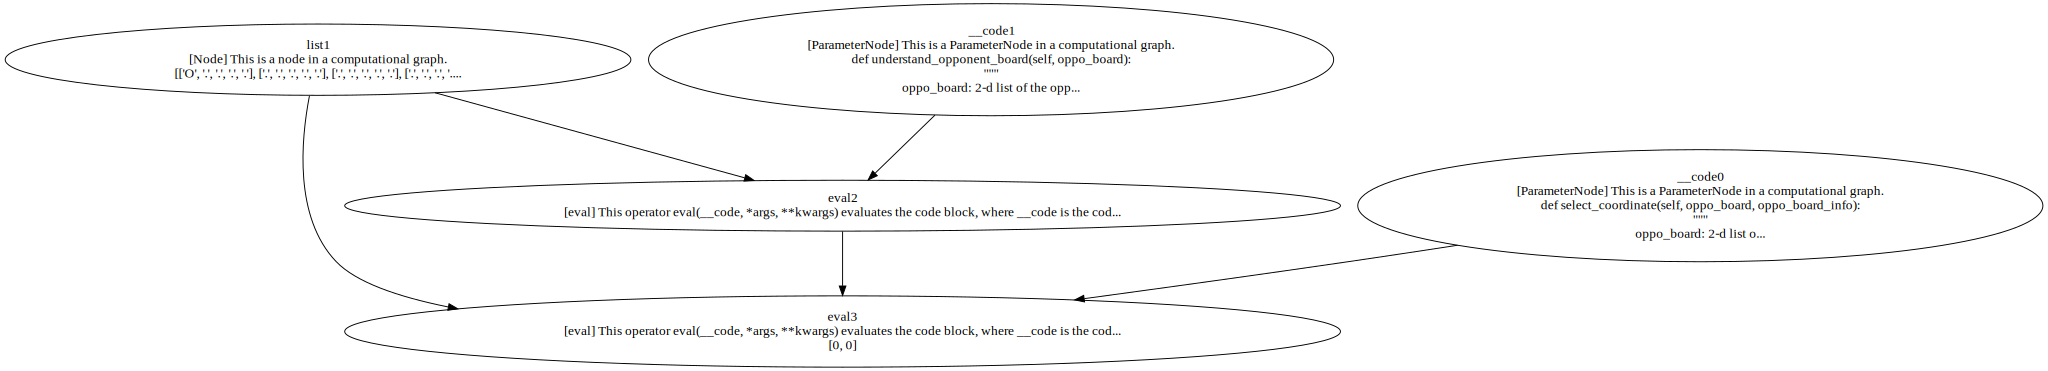

In [19]:
agent = Agent()
obs = node(board.get_shots(), trainable=False)
output = agent.act(obs)
output.backward(visualize=True)

In [27]:
GRAPH.clear()

board = BattleshipBoard(5, 5, num_each_type=1, exclude_ships=["C", "B"])
print("Ground State Board")
board.visualize_board()

agent = Agent()
obs = node(board.get_shots(), trainable=False)
optimizer = FunctionOptimizer(agent.parameters(), config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

feedback = ""
terminal = False
cum_reward = 0
max_calls = 10

while not terminal and max_calls > 0:
    # This is also online optimization
    # we have the opportunity to keep changing the function with each round of interaction
    try:
        output = agent.act(obs)
        obs, reward, terminal, feedback = user_fb_for_placing_shot(board, output.data)
        hint = f"The current code gets {reward}. We should try to get more reward based on whatever observation we see."
        optimizer.objective = f"{optimizer.default_objective} Hint: {hint}"
    except TraceExecutionError as e:
        # this is essentially a retry
        output = e.exception_node
        feedback = output.data
        terminal = False
        reward = 0

    print("Obs:")
    board.visualize_shots()
    print("reward:", reward)

    cum_reward += reward

    optimizer.zero_feedback()
    optimizer.backward(output, feedback)

    print(f"output={output.data}, feedback={feedback}, variables=\n")  # logging
    for p in optimizer.parameters:
        print(p.name, p.data)
    optimizer.step(verbose=False)
    max_calls -= 1

Ground State Board
. . . . .
. S S S .
. . D . .
. . D . .
. R R R .

Obs:
O . . . .
. . . . .
. . . . .
. . . . .
. . . . .

reward: False
output=[0, 0], feedback=Got False reward., variables=

__code:0 def select_coordinate(self, oppo_board, oppo_board_info):
        """
        oppo_board: 2-d list of the opponent's board, with '.' showing undiscovered area, 'X' showing hit, 'O' showing miss
        oppo_board_info: some additional information processed by another function
        our_board_info: some additional information processed by another function

        Can use a variable to store your thought process, it shouldn't
        """
        return [0, 0]
__code:1 def understand_opponent_board(self, oppo_board):
        """
        oppo_board: 2-d list of the opponent's board, with '.' showing undiscovered area, 'X' showing hit, 'O' showing miss
        Returns: we should return some information for another function that is placing the shot.
        """
        return ""
Obs:
O O 

In [29]:
board.get_shots()

[['O', 'O', '.', '.', '.'],
 ['O', '.', 'X', '.', '.'],
 ['O', '.', 'X', 'O', '.'],
 ['.', 'O', '.', 'O', 'O'],
 ['.', '.', '.', '.', '.']]

## Scenario 2.1

Now we are playing against a pre-programmed opponent

In [3]:
@trace_class
class Agent:
    @bundle(trainable=True, allow_external_dependencies=True)
    def select_coordinate(self, oppo_board, oppo_board_info, own_board_info):
        """
        oppo_board: 2-d list of the opponent's board, with '.' showing undiscovered area, 'X' showing hit, 'O' showing miss
        oppo_board_info: some additional information processed by another function
        our_board_info: some additional information processed by another function

        can use a variable to store your thought process, it shouldn't
        """
        # Thoughts: we can use the opponent's board to figure out where to place shots
        return [0, 0]

    @bundle(trainable=True, allow_external_dependencies=True)
    def understand_own_board(self, board):
        """
        board: 2-d list of our own board, with "." showing open water, and letters C/B/R/S/D showing shape of ships.
               'O' means opponent's missed shots.
               'X' means opponent's hit shots.
        Returns: we should return some information for another function that is placing the shot.
        """
        # Thoughts:
        return ""

    @bundle(trainable=True, allow_external_dependencies=True)
    def understand_opponent_board(self, oppo_board):
        """
        oppo_board: 2-d list of the opponent's board, with '.' showing undiscovered area, 'X' showing hit, 'O' showing miss
        Returns: we should return some information for another function that is placing the shot.
        """
        # Thoughts:
        return ""

    def act(self, oppo_board, own_board):
        oppo_board_info = self.understand_opponent_board(oppo_board)
        own_board_info = self.understand_own_board(own_board)
        return self.select_coordinate(oppo_board, oppo_board_info, own_board_info)

In [11]:
def opponent_agent(map):
    # funny enough, this is written by the LLM already
    for i in range(len(map)):
        for j in range(len(map[0])):
            if map[i][j] != "O":
                first_non_O = [i, j]
        else:
            continue
    return first_non_O if "first_non_O" in locals() else [0, 0]


def user_fb_for_one_round_of_game(oppo_board, own_board, coords):
    # this is already a multi-step cumulative reward problem
    # obs, reward, terminal, feedback
    try:
        reward = oppo_board.check_shot(coords[0], coords[1])
        new_map = oppo_board.get_shots()

        # now opponent plays
        coords = opponent_agent(own_board.get_shots())
        oppo_rew = own_board.check_shot(coords[0], coords[1])
        new_own_map = own_board.get_shots()

        if oppo_board.check_terminate() or own_board.check_terminate():
            terminal = True
        else:
            terminal = False

        reward = reward - oppo_rew

        return new_map, new_own_map, reward, terminal, f"Got {reward} reward."
    except Exception as e:
        return oppo_board.get_shots(), own_board.get_shots(), -10, False, str(e)

In [12]:
GRAPH.clear()

own_board = BattleshipBoard(5, 5, num_each_type=1, exclude_ships=["C", "B"])
oppo_board = BattleshipBoard(5, 5, num_each_type=1, exclude_ships=["C", "B"])
print("Ground State Board")
oppo_board.visualize_board()

agent = Agent()
obs = node(oppo_board.get_shots(), trainable=False)
own_obs = node(own_board.get_shots_overlay_board(), trainable=False)
optimizer = FunctionOptimizer(agent.parameters(), config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

feedback = ""
terminal = False
cum_reward = 0
max_calls = 10

while not terminal and max_calls > 0:
    # This is also online optimization
    # we have the opportunity to keep changing the function with each round of interaction
    try:
        output = agent.act(obs, own_obs)
        obs, own_obs, reward, terminal, feedback = user_fb_for_one_round_of_game(oppo_board, own_board, output.data)
        hint = (
            "You are playing against an opponent. You get +1 reward if you hit their ship. You get -1 reward if your ship gets hit.\n"
            + "You get 0 reward if in the same turn both you and your opponent landed a shot.\n"
            + "You get -10 reward if your program has an error."
            + f"The current code gets {reward}. We should try to get more reward based on whatever observation we see."
        )
        optimizer.objective = f"{optimizer.default_objective} Hint: {hint}"
    except TraceExecutionError as e:
        # this is essentially a retry
        output = e.exception_node
        feedback = output.data
        terminal = False
        reward = 0

    print("Oppo Board:")
    oppo_board.visualize_shots()
    print("Own Board:")
    print(own_board.visualize_own_board())
    print("reward:", reward)

    cum_reward += reward

    optimizer.zero_feedback()
    optimizer.backward(output, feedback)

    print(f"output={output.data}, feedback={feedback}, variables=\n")  # logging
    for p in optimizer.parameters:
        print(p.name, p.data)
    optimizer.step(verbose=False)
    max_calls -= 1

Ground State Board
. . . . .
. . . . .
. . D D .
. . R R R
. . S S S

Oppo Board:
O . . . .
. . . . .
. . . . .
. . . . .
. . . . .

Own Board:
[['.', '.', '.', '.', 'R'], ['.', '.', '.', '.', 'R'], ['.', '.', '.', 'S', 'R'], ['.', 'D', '.', 'S', '.'], ['.', 'D', '.', 'S', 'O']]
reward: 0
output=[0, 0], feedback=Got 0 reward., variables=

__code:0 def select_coordinate(self, oppo_board, oppo_board_info, own_board_info):
        """
        oppo_board: 2-d list of the opponent's board, with '.' showing undiscovered area, 'X' showing hit, 'O' showing miss
        oppo_board_info: some additional information processed by another function
        our_board_info: some additional information processed by another function

        can use a variable to store your thought process, it shouldn't
        """
        # Thoughts: we can use the opponent's board to figure out where to place shots
        return [0, 0]
__code:1 def understand_own_board(self, board):
        """
        board: 2-d lis